In [174]:
import ae352_quadrotor_new
import matplotlib.pyplot as plt
import numpy as np
from sympy import *
from control.matlab import ctrb
import control as ctrl
import scipy

In [175]:
# Beginning paramters

# Quadcopter data
m = 0.249       # kg
Ixx = 0.0023
Iyy = 0.0023
Izz = 0.0040

l = 0.175       # m

# Enviromental Data
g = 9.81        # m/s^2

In [176]:
# Position (m)
px, py, pz = symbols('p_x, p_y, p_z')

# roll, pitch, yaw (rad)
phi, theta, psi = symbols('phi, theta, psi')

# Velocity
vx, vy, vz = symbols("v_x, v_y, v_z")
v_B = Matrix([vx, vy, vz])

# Angular Velocity
wx, wy, wz = symbols("w_x, w_y, w_z")
w_B = Matrix([wx, wy, wz])

# Torques (equal to thrust for our purposes)
taux, tauy, tauz = symbols('tau_x, tau_y, tau_z')
tau_B = Matrix([taux, tauy, tauz])

# Force in z
fz = symbols("f_z")

# Inertia Matrix
I = diag(Ixx, Iyy, Izz)


In [177]:
# Setting up for EOMs

# Rotation Matrices
Rz = Matrix([[cos(psi), -sin(psi), 0],
             [sin(psi), cos(psi), 0],
             [0, 0, 1]])
Ry = Matrix([[cos(theta), 0, sin(theta)],
             [0, 1, 0],
             [-sin(theta), 0, cos(theta)]])
Rx = Matrix([[1, 0, 0],
             [0, cos(phi), -sin(phi)],
             [0, sin(phi), cos(phi)]])
R_W = Rz @ Ry @ Rx
R_B = R_W.T

# Angular Velocity to Angles
ex = Matrix([[1], [0], [0]])
ey = Matrix([[0], [1], [0]])
ez = Matrix([[0], [0], [1]])
M = simplify(Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Net forces on Body
f_B = R_B @ Matrix([[0], [0], [-m*g]]) + Matrix([[0], [0], [fz]])

In [178]:
# Equations of Motion

# Velocity Derivatives
vdot = (f_B - w_B.cross(m * v_B))/m

#  Position Derivatives
pdot = R_W @ v_B

# Angular Derivatives
angdot = M @ w_B

# Ang Velocity Derivatives
wdot = I.inv() @ (tau_B - w_B.cross(I @ w_B))

f = Matrix.vstack(pdot, angdot, vdot, wdot)
f = simplify(f, full=True)
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                              1.0*v_y*w_z - 1.0*v_z*w_y + 9.81*sin(theta)],
[   

In [179]:
# Equilibrium

# pos
(px_e, py_e, pz_e) = (0,0,0)

#yaw, pitch, roll
(psi_e, theta_e, phi_e) = (0,0,0)

#linear vel
(vx_e, vy_e, vz_e) = (0,0,0)

#angular vel
(wx_e, wy_e, wz_e) = (0,0,0)

#net rotor torque
(taux_e, tauy_e, tauz_e) = (0,0,0)

#net rotor force
fz_e = m*9.81 #Net rotor force has to counteract gravity for equilibrium to be hover

fe = f.subs(((px,px_e), (py, py_e), (pz, pz_e), (psi, psi_e), (psi, psi_e), (theta, theta_e),
            (phi, phi_e), (vx, vx_e), (vy, vy_e), (vz, vz_e), (wx, wx_e), (wy, wy_e),
            (wz, wz_e), (taux, taux_e), (tauy, tauy_e), (tauz, tauz_e), (fz, fz_e)))
fe  # All values are 0 so a real equilibrium.

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])

In [180]:
# Position of markers in body frame Acknowledgement to GRAYKS3248 Condynsate Template

p_W = Matrix([px, py, pz])

lxy=0.25 #x or y distance from quadrotor frame to markers in m CHANGE TO OUR MODEL DISTANCE
lz=0.046875 # The z distance from the quadrotor frame to the markers in m CHANGE TO OUR DISTANCE


mark1_inB = Matrix([[lxy],
                        [0.],
                        [lz]])
mark2_inB = Matrix([[0.],
                        [lxy],
                        [lz]])
mark3_inB = Matrix([[-lxy],
                        [0.],
                        [lz]])
mark4_inB = Matrix([[0.],
                        [-lxy],
                        [lz]])

# Position of markers in world frame
mark1_inW = p_W + R_W @ mark1_inB
mark2_inW = p_W + R_W @ mark2_inB
mark3_inW = p_W + R_W @ mark3_inB
mark4_inW = p_W + R_W @ mark4_inB

# Sensor model
n = simplify(Matrix.vstack(mark1_inW, mark2_inW, mark3_inW, mark4_inW))

n

Matrix([
[                                  p_x + 0.046875*sin(phi)*sin(psi) + 0.046875*sin(theta)*cos(phi)*cos(psi) + 0.25*cos(psi)*cos(theta)],
[                                  p_y - 0.046875*sin(phi)*cos(psi) + 0.046875*sin(psi)*sin(theta)*cos(phi) + 0.25*sin(psi)*cos(theta)],
[                                                                                 p_z - 0.25*sin(theta) + 0.046875*cos(phi)*cos(theta)],
[p_x + 0.046875*sin(phi)*sin(psi) + 0.25*sin(phi)*sin(theta)*cos(psi) - 0.25*sin(psi)*cos(phi) + 0.046875*sin(theta)*cos(phi)*cos(psi)],
[p_y + 0.25*sin(phi)*sin(psi)*sin(theta) - 0.046875*sin(phi)*cos(psi) + 0.046875*sin(psi)*sin(theta)*cos(phi) + 0.25*cos(phi)*cos(psi)],
[                                                                        p_z + 0.25*sin(phi)*cos(theta) + 0.046875*cos(phi)*cos(theta)],
[                                  p_x + 0.046875*sin(phi)*sin(psi) + 0.046875*sin(theta)*cos(phi)*cos(psi) - 0.25*cos(psi)*cos(theta)],
[                               

In [181]:
# Equilibrium for the Sensor Model
n_e=n.subs({px:px_e, 
            py:py_e,
            pz:pz_e,
            psi:psi_e, 
            theta:theta_e,
            phi:phi_e,
            vx:vx_e, 
            vy:vy_e, 
            vz:vz_e,
            wx:wx_e, 
            wy:wy_e, 
            wz:wz_e,})

n_e=np.array(n_e)
n_e

array([[0.250000000000000],
       [0],
       [0.0468750000000000],
       [0],
       [0.250000000000000],
       [0.0468750000000000],
       [-0.250000000000000],
       [0],
       [0.0468750000000000],
       [0],
       [-0.250000000000000],
       [0.0468750000000000]], dtype=object)

In [182]:
# Define A,B,C,D matrices

A = f.jacobian([px,py,pz,psi,theta,phi,vx,vy,vz,wx,wy,wz]).subs(((px,px_e), (py, py_e), (pz, pz_e), (psi, psi_e), (psi, psi_e), (theta, theta_e),
            (phi, phi_e), (vx, vx_e), (vy, vy_e), (vz, vz_e), (wx, wx_e), (wy, wy_e),
            (wz, wz_e), (taux, taux_e), (tauy, tauy_e), (tauz, tauz_e), (fz, fz_e)))

B = f.jacobian([taux, tauy, tauz, fz]).subs(((px,px_e), (py, py_e), (pz, pz_e), (psi, psi_e), (psi, psi_e), (theta, theta_e),
            (phi, phi_e), (vx, vx_e), (vy, vy_e), (vz, vz_e), (wx, wx_e), (wy, wy_e),
            (wz, wz_e), (taux, taux_e), (tauy, tauy_e), (tauz, tauz_e), (fz, fz_e)))


C = n.jacobian([px,py,pz,psi,theta,phi,vx,vy,vz,wx,wy,wz]).subs(((px,px_e), (py, py_e), (pz, pz_e), (psi, psi_e), (psi, psi_e), (theta, theta_e),
            (phi, phi_e), (vx, vx_e), (vy, vy_e), (vz, vz_e), (wx, wx_e), (wy, wy_e),
            (wz, wz_e), (taux, taux_e), (tauy, tauy_e), (tauz, tauz_e), (fz, fz_e)))

D = n.jacobian([taux, tauy, tauz, fz]).subs(((px,px_e), (py, py_e), (pz, pz_e), (psi, psi_e), (psi, psi_e), (theta, theta_e),
            (phi, phi_e), (vx, vx_e), (vy, vy_e), (vz, vz_e), (wx, wx_e), (wy, wy_e),
            (wz, wz_e), (taux, taux_e), (tauy, tauy_e), (tauz, tauz_e), (fz, fz_e)))
A, B

(Matrix([
 [0, 0, 0, 0,    0,     0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0,    0,     0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0,    0,     0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0,    0,     0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0,    0,     0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0,    0,     0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 9.81,     0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0,    0, -9.81, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0,    0,     0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0,    0,     0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0,    0,     0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0,    0,     0, 0, 0, 0, 0, 0, 0]]),
 Matrix([
 [               0,                0,     0,                0],
 [               0,                0,     0,                0],
 [               0,                0,     0,                0],
 [               0,                0,     0,                0],
 [               0,                0,     0,                0],
 [               0,                0,     0,                0],
 [               0,                0,     

In [183]:
# Testing Controlability and Observabillity
W = ctrb(A,B)

rank = np.linalg.matrix_rank(W)
print(rank)
print(W.shape)

O = ctrl.obsv(A,C)

rank = np.linalg.matrix_rank(O)
print(rank)
print(O.shape)

12
(12, 48)
12
(144, 12)


In [308]:
# Defining K,L matrix

# K matrix
Q = np.diag([3e4,3e4,3e4,5e3,5e3,5e3,1,1,1,1,1,1])
R = np.diag([3e4,3e4,3e4,10])

A = np.array(A).astype(np.float64)
B = np.array(B).astype(np.float64)
C = np.array(C).astype(np.float64)

P = scipy.linalg.solve_continuous_are(A,B,Q,R)
K = np.linalg.inv(R) @ B.T @ P
K = Matrix(K)

# L matrix
Q_L = np.identity(C.shape[0])
R_L = np.identity(A.shape[0])
Qinv = np.linalg.inv(Q_L)
Rinv = np.linalg.inv(R_L)

P = scipy.linalg.solve_continuous_are(A.T,C.T,Qinv,Rinv)
L = np.linalg.inv(Rinv) @ C.T @ P
L = Matrix(L).T
print(K)
print(L)

Matrix([[-6.43809020738993e-15, -0.999999999999993, -7.12970218306185e-15, 1.15215878208739e-15, -5.84904290538480e-17, 0.763035989751002, -1.44092233599378e-15, -0.394456875017955, -3.45033578208172e-16, 0.0595256153784902, 1.29472562108061e-16, 1.69089034827020e-16], [0.999999999999996, 1.40856267389235e-14, 4.28506601192404e-17, 3.28854049014862e-15, 0.763035989751001, -1.45533138741300e-15, 0.394456875017955, 3.62880746255587e-15, 2.56289999520742e-18, 1.29472562108061e-16, 0.0595256153784899, 5.80585541682081e-16], [8.76112178749818e-15, -6.22995328207146e-15, -7.86342070339777e-15, 0.408248290463863, 4.30186648506654e-15, 1.89801140013930e-15, 3.17903757170203e-15, -1.95604970163346e-15, 1.95792114403920e-16, 9.72261950255364e-17, 3.33836686467197e-16, 0.0574397045347922], [-1.27136807816863e-14, 2.72084506371225e-13, 54.7722557505165, 6.30721550918281e-14, 5.38000110519154e-15, -1.37218467692956e-13, 5.28906570949198e-16, 1.07714415607246e-13, 5.23226369401976, -9.56117144432284

In [309]:
# Checking Stablility
K = np.array(K).astype(np.float64)
xdot = A - B @ K
print(np.linalg.eigvals(xdot)) # All negative so its stable!

L = np.array(L).astype(np.float64)
xdot_error = A - L@C
print(np.linalg.eigvals(xdot_error)) # All negative so its detectable!

[ -3.47891423 +3.48625421j  -3.47891423 -3.48625421j
  -3.47891423 +3.48625421j  -3.47891423 -3.48625421j
  -7.17996307 +7.10705304j  -7.17996307 -7.10705304j
  -9.46143694 +9.29069783j  -9.46143694 -9.29069783j
  -9.46143694 +9.29069783j  -9.46143694 -9.29069783j
 -10.5065536 +10.46810537j -10.5065536 -10.46810537j]
[-1.25108903+4.04797824j -1.25108903-4.04797824j -2.21723823+3.28982072j
 -2.21723823-3.28982072j -2.16345126+0.12082335j -2.16345126-0.12082335j
 -0.53785117+1.32124227j -0.53785117-1.32124227j -0.97175182+0.59760008j
 -0.97175182-0.59760008j -0.18299914+0.44651375j -0.18299914-0.44651375j]


In [310]:
# Performance Goal 1

class Controller:
    def __init__(self):

        self.dt = 0.01

        self.variables_to_log = ['x_hat', 'xdes']

        self.A = np.array(A, dtype=float)
        self.B = np.array(B, dtype=float)
        self.C = np.array(C, dtype=float)
        self.K = np.array(K, dtype=float)
        self.L = np.array(L, dtype=float)



        self.taux_e = 0
        self.tauy_e = 0
        self.tauz_e = 0
        self.fz_e = g*m
        print(g)

    def reset(self, p_x=0, p_y=0, p_z=0, yaw=0):
        self.x_hat = np.array([p_x, p_y, p_z, yaw, 0, 0, 0, 0, 0, 0, 0, 0], dtype=float)
        self.xdes = np.zeros(12, dtype=float)

    def run(self, **kwargs):

        mocap1=kwargs['mocap_1']
        mocap2=kwargs['mocap_2']
        mocap3=kwargs['mocap_3']
        mocap4=kwargs['mocap_4']
        
        dt = kwargs.get('dt', 0.01)

        pos_markers = np.array([mocap1[0],mocap1[1],mocap1[2],
                                mocap2[0],mocap2[1],mocap2[2],
                                mocap3[0],mocap3[1],mocap3[2],
                                mocap4[0],mocap4[1],mocap4[2],])
        
        xdes = np.zeros(12)
        pos = self.x_hat[0:3]
        fpos = np.array([0, 0, 1])

# -----------------------------------------
        #Hover at 1m above the ground
        e_max = 0.01
    
        if np.linalg.norm(fpos - pos) > 0.1:
            pdes = pos + e_max * ((fpos - pos) / np.linalg.norm(fpos - pos))
            vdes = 0.5 * ((fpos - pos) / np.linalg.norm(fpos - pos))
        elif np.linalg.norm(fpos - pos) > 0.05:
            pdes = pos + e_max * ((fpos - pos) / np.linalg.norm(fpos - pos))
            vdes = 0.05 * ((fpos - pos) / np.linalg.norm(fpos - pos))
        elif np.linalg.norm(fpos - pos) > 0.01:
            pdes = pos + e_max * ((fpos - pos) / np.linalg.norm(fpos - pos))
            vdes = 0.007 * ((fpos - pos) / np.linalg.norm(fpos - pos))
        else:
            pdes = fpos
            vdes = 0.001 * ((fpos - pos) / np.linalg.norm(fpos - pos))
# -----------------------------------------
        
        xdes[0:3] = pdes
        xdes[6:9] = vdes
        self.xdes = xdes
    
        u = -self.K @ (self.x_hat - self.xdes)
    
        y = pos_markers
    
        self.x_hat += dt * (self.A @ self.x_hat + self.B @ u - self.L @ (self.C @ self.x_hat - y))
    
        taux = u[0]
        tauy = u[1]
        tauz = u[2]
        fz = u[3] + self.fz_e
    
        return taux, tauy, tauz, fz

In [311]:
# Performance Goal 2

# class Controller:
#     def __init__(self):

#         self.dt = 0.01

#         self.variables_to_log = ['x_hat', 'xdes']

#         self.A = A
#         self.B = B
#         self.C = C
#         self.K = K
#         self.L = L

#         self.taux_e = 0
#         self.tauy_e = 0
#         self.tauz_e = 0
#         self.fz_e = g*m
       
#         self.phase=0 #phase 0 - go to 1m altitude, phase 1 - go forward 2m, phase 2 - rotate around origin
#         self.theta=3*np.pi/2 #starting angle when rotation begins
  
    
#     def reset(self, p_x=0, p_y=0, p_z=0, yaw=0):
#         self.x_hat = np.array([p_x, p_y, p_z, yaw, 0, 0, 0, 0, 0, 0, 0, 0], dtype=float)
#         self.xdes = np.zeros(12, dtype=float)

#     def run(self, **kwargs):

#         mocap1=kwargs['mocap_1']
#         mocap2=kwargs['mocap_2']
#         mocap3=kwargs['mocap_3']
#         mocap4=kwargs['mocap_4']
        
#         dt = kwargs.get('dt', 0.01)

#         pos_markers = np.array([mocap1[0],mocap1[1],mocap1[2],
#                                 mocap2[0],mocap2[1],mocap2[2],
#                                 mocap3[0],mocap3[1],mocap3[2],
#                                 mocap4[0],mocap4[1],mocap4[2],])
        
#         xdes = np.zeros(12)
#         pos = self.x_hat[0:3]

# # -----------------------------------------
#         #Getting the drone to 1m 

#         e_max = 0.01

#         if self.phase==0:
#             fpos=np.array([0, 0, 1])
#             if np.linalg.norm(fpos - pos) > 0.1:
#                 pdes = pos +  e_max * ((fpos - pos) / np.linalg.norm(fpos - pos))
#                 vdes = 0.5 * ((fpos - pos) / np.linalg.norm(fpos - pos))
#             elif np.linalg.norm(fpos-pos) > 0.05:
#                 pdes = pos +  e_max * ((fpos - pos) / np.linalg.norm(fpos - pos))
#                 vdes = 0.05 * ((fpos - pos) / np.linalg.norm(fpos - pos))    
#             elif np.linalg.norm(fpos-pos) > 0.01:
#                 pdes = pos +  e_max * ((fpos - pos) / np.linalg.norm(fpos - pos))
#                 vdes = 0.007 * ((fpos - pos) / np.linalg.norm(fpos - pos))  

#             else:
#                 pdes = fpos
#                 vdes = np.zeros(3)
#                 self.phase = 1
# # -----------------------------------------
#         #Have frone fly in circle of 2m at 0.5 m/s
        
#         elif self.phase==1:
#             radius=2
#             center=np.array([0,2,1])
#             speed=0.5

#             omega=speed/radius #angular velocity w=v/R

#             self.theta += omega*self.dt

#             self.theta = self.theta % (2*np.pi)

#             x = center[0] + radius*np.cos(self.theta)
#             y = center[1] + radius*np.sin(self.theta)

#             fpos=np.array([x,y,1]) #altitude is constant

#             if np.linalg.norm(fpos - pos) > 0.01:
#                 pdes = pos +  e_max * ((fpos - pos) / np.linalg.norm(fpos - pos))
#                 vdes = 0.5 * ((fpos - pos) / np.linalg.norm(fpos - pos)) 
                
#             else:
#                 pdes = fpos
#                 vdes = np.zeros(3)
# # -----------------------------------------
        
#         xdes[0:3] = pdes
#         xdes[6:9] = vdes
#         self.xdes = xdes

#         u = -self.K @ (self.x_hat - self.xdes)

#         y = pos_markers

#         self.x_hat += self.dt * (self.A @ self.x_hat + self.B @ u - self.L @ (self.C @ self.x_hat - y))
        
#         taux = u[0]
#         tauy = u[1]
#         tauz = u[2]
#         fz = u[3] + self.fz_e

#         return taux, tauy, tauz, fz

In [312]:
# Performance Goal 3, we gave up

In [313]:
controller1=Controller()
team_list = [""]
sim = ae352_quadrotor_new.Quadrotor_Sim(n_quadrotors=1,
                                    team_list=team_list,
                                    planet="Earth",
                                    use_keyboard=True,
                                    visualization=True,
                                    visualization_fr=45.,
                                    animation=False,
                                    verbose=True)

9.81
Termination command detected. Terminating keyboard listener. Goodbye
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7018/static/


In [314]:
controllers = [controller1]
(track_stats, data) = sim.run(controllers,
                              sensor_noise=0.,
                              collect_data=True,
                              max_time=60*2.0, #change time based on performance goal
                              verbose=True)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
QUITTING...


Termination command detected. Terminating keyboard listener. Goodbye


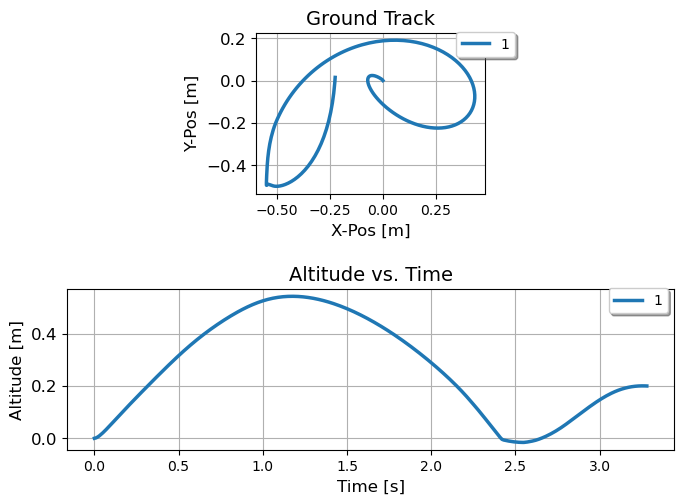

<Figure size 640x480 with 0 Axes>

In [306]:
# Create a figure that has two plots in it
import matplotlib.ticker as ticker
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=False)

# Convert the position data to array
for i in range(len(data)):
    
    # Get the position
    pos = np.array(data[i]['position'])
    
    # Create a plot of the ground path of the quadrotor
    axes[0].plot(pos[:,0], pos[:,1], lw=2.5, label=str(i+1))
    
    # Create a plot of the altitude versus time
    axes[1].plot(data[0]['time'], pos[:,2], lw=2.5, label=str(i+1))

# Make plot 0 pretty
axes[0].set_xlabel("X-Pos [m]", fontsize=12)
axes[0].set_ylabel("Y-Pos [m]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].legend(bbox_to_anchor=(1.16, 1.05), fancybox=True, shadow=True)
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Altitude [m]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].legend(bbox_to_anchor=(1., 1.05), fancybox=True, shadow=True)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()
plt.savefig('ground_track_sim_3_2.png')

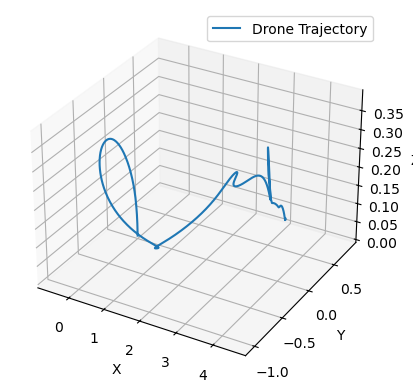

<Figure size 640x480 with 0 Axes>

In [190]:
# TRAJECTORY TRACKING

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(data)):
    
    # Get the position
    pos = np.array(data[i]['position'])

    drone_x = pos[:,0]
    drone_y = pos[:,1]
    drone_z = pos[:,2]



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.plot3D(drone_x, drone_y, drone_z, label='Drone Trajectory')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()

plt.show()
plt.savefig('3d-graph_sim_3_2.png')

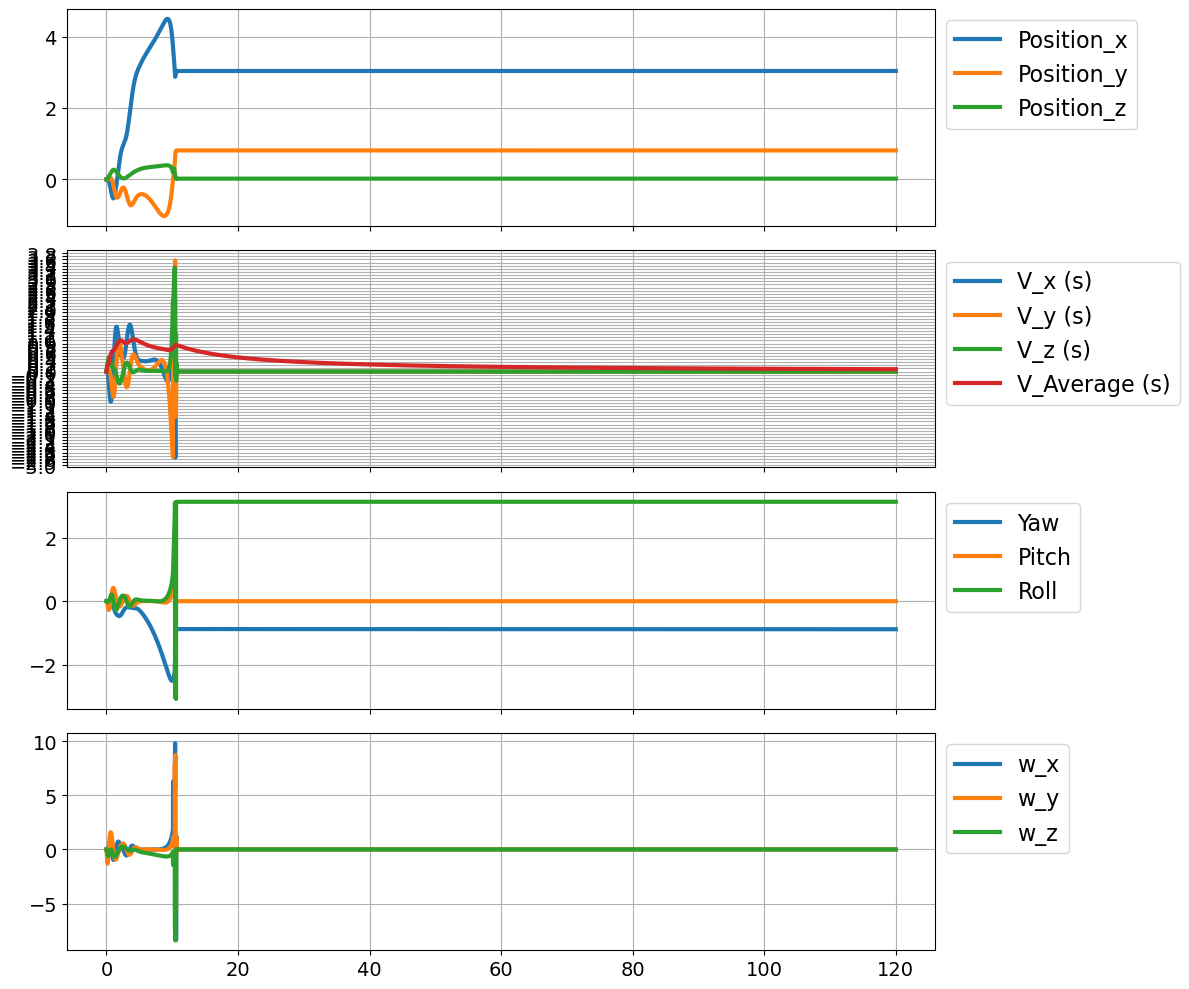

In [191]:
import matplotlib.ticker as ticker

fig, (ax_pos, ax_vel, ax_ori, ax_ang) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# -----------------------------------------

# Position

for i in range(len(data)):
    
    t = np.array(data[i]['time'])
    
    pos = np.array(data[i]['position'])

    p_x = pos[:,0]
    p_y = pos[:,1]
    p_z = pos[:,2]

ax_pos.plot(t, p_x, label='Position_x', linewidth=3, color='C0')
ax_pos.plot(t, p_y, label='Position_y', linewidth=3, color='C1')
ax_pos.plot(t, p_z, label='Position_z', linewidth=3, color='C2')

ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# -----------------------------------------

# Velocity

for i in range(len(data)):
    
    t = np.array(data[i]['time'])
    
    vel = np.array(data[i]['velocity'])

    v_x = vel[:,0]
    v_y = vel[:,1]
    v_z = vel[:,2]

    v_mag = np.sqrt(v_x**2 + v_y**2 + v_z**2)
    v_avg = np.cumsum(v_mag) / np.arange(1, len(v_mag)+1)

ax_vel.plot(t, v_x, label='V_x (s)', linewidth=3, color='C0')
ax_vel.plot(t, v_y, label='V_y (s)', linewidth=3, color='C1')
ax_vel.plot(t, v_z, label='V_z (s)', linewidth=3, color='C2')
ax_vel.plot(t, v_avg, label='V_Average (s)', linewidth=3, color='C3')
ax_vel.grid()
ax_vel.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
ax_vel.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_vel.tick_params(labelsize=14)

# -----------------------------------------

# Orientation

for i in range(len(data)):
    
    t = np.array(data[i]['time'])
    
    ori = np.array(data[i]['orientation'])

    yaw = ori[:,0]
    pitch = ori[:,1]
    roll = ori[:,2]

ax_ori.plot(t, yaw, label='Yaw', linewidth=3, color='C0')
ax_ori.plot(t, pitch, label='Pitch', linewidth=3, color='C1')
ax_ori.plot(t, roll, label='Roll', linewidth=3, color='C2')
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)
fig.tight_layout()

# -----------------------------------------

#Angular Velocity

for i in range(len(data)):
    
    t = np.array(data[i]['time'])
    
    ang = np.array(data[i]['angular velocity'])

    ang_x = ang[:,0]
    ang_y = ang[:,1]
    ang_z = ang[:,2]

ax_ang.plot(t, ang_x, label='w_x', linewidth=3, color='C0')
ax_ang.plot(t, ang_y, label='w_y', linewidth=3, color='C1')
ax_ang.plot(t, ang_z, label='w_z', linewidth=3, color='C2')
ax_ang.grid()
ax_ang.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ang.tick_params(labelsize=14)
fig.tight_layout()
plt.show()

In [192]:
plt.savefig('all_data_sim_3_2.png')

<Figure size 640x480 with 0 Axes>